第1129行之后是有效数据
              16      7 
1128    0.000000  0.0000
1129    0.016667  0.0012
1130    0.066667  0.0028
1131    0.166667  0.0054
1132    0.266667  0.0064
...          ...     ...
3293  199.187228  7.7362
3294  199.287228  7.8070
3295  199.370561  7.8674
3296  199.462700  7.9346
3297  199.546034  7.9962

[2170 rows x 2 columns]


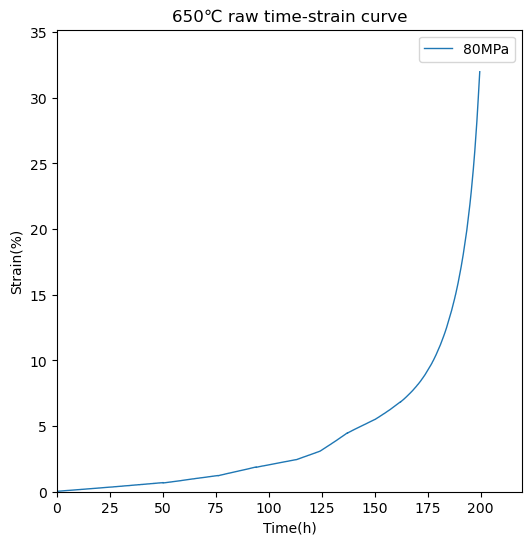

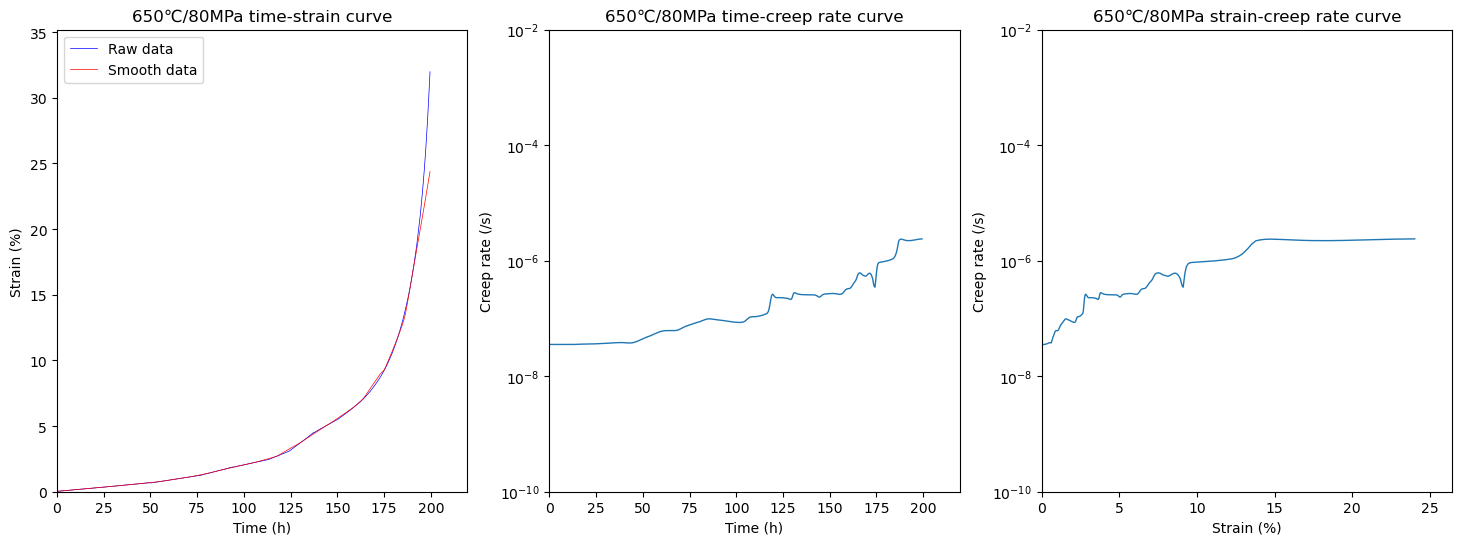

D:\Anaconda\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [1]:


import pandas as pd
import numpy as np
import statsmodels.api as sm
import tkinter as tk
import matplotlib.pyplot as plt
from tkinter import filedialog
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False  


smooth_frac = [0.13]#数据平滑因子
point_number = 500#数据点数
strain_threshold = 100#应变门槛(%)，大于这个应变的数据去掉
time_threshold = 5000#时间门槛(h)，大于这个时间的数据去掉
temperature = 650#实验温度℃
load = 7.07 #实验载荷kN
Stress = [80]#实验的应力MPa
H = [25]#试样的标距mm






root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()




txt_file_name = f"RDL100_auto_{temperature}℃_{Stress[0]}MPa优化调参.txt"
txt_file_path = file_path[:file_path.rfind('/') + 1] + txt_file_name
with open(txt_file_path, 'w') as f:
    f.write(f"smooth_frac = {smooth_frac}#数据平滑因子\n")
    f.write(f"point_number = {point_number}#数据点数\n")
    f.write(f"strain_threshold = {strain_threshold}##应变门槛(%)，大于这个应变的数据去掉\n")
    f.write(f"time_threshold = {time_threshold}#时间门槛(h)，大于这个时间的数据去掉\n")
    f.write(f"temperature = {temperature}#实验温度℃\n")
    f.write(f"load = {load}#实验载荷kN\n")
    f.write(f"Stress = {Stress}#实验的应力MPa\n")
    f.write(f"H = {H}#试样的标距mm\n")











new_file_name = f"RDL100_auto_{temperature}℃_{Stress[0]}MPa.xlsx"

new_file_path = file_path[:file_path.rfind('/') + 1] + new_file_name
writer = pd.ExcelWriter(new_file_path)



df1 = pd.read_csv(file_path, delimiter=',', header=None)


for i in range(len(df1)):

    if df1.iloc[i, 3] > load:
        print(f'第{i+1}行之后是有效数据')
        break

df2 = df1.iloc[i:, [16, 7]]


for col in df2.columns:
    df2[col] = df2[col] - df2.iloc[0, df2.columns.get_loc(col)]
print(df2)

df2.iloc[:, 1] = df2.iloc[:, 1].div(H[0]) * 100

df2.iloc[:, 1] = df2.iloc[:, 1].where(df2.iloc[:, 1] <= strain_threshold, 0)

df2.iloc[:, 1] = df2.iloc[:, 1].where(df2.iloc[:, 0] <= time_threshold, 0)


time = df2.iloc[:, 0].values
strain = df2.iloc[:, 1].values




strain = np.nan_to_num(strain,
                       nan=0,
                       posinf=np.max(strain),
                       neginf=np.min(strain))
time = np.nan_to_num(time, nan=0, posinf=np.max(time), neginf=np.min(time))


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f'{temperature}℃ raw time-strain curve')
ax.set_xlabel('Time(h)')
ax.set_ylabel('Strain(%)')
ax.set_xlim(0, time[-1] * 1.1)
ax.set_ylim(0, np.max(strain) * 1.1)

mask = np.where(strain != 0, True, False)  
ax.plot(time[mask], strain[mask], label=f'{Stress[0]}MPa', lw=1)

ax.legend()
plt.show()


new_time = np.zeros((point_number, 1))
new_strain = np.zeros((point_number, 1))
new_time_new = np.zeros((point_number - 1, 1))
new_strain_new = np.zeros((point_number - 1, 1))
minimum_result = np.zeros((1, 4))

for i in range(1):

    mask = np.where(strain != 0, True, False)  
    lowess = sm.nonparametric.lowess(strain[mask],
                                     time[mask],
                                     frac=smooth_frac[0])  
    new_time[:, i] = np.linspace(time[mask][0], time[mask][-1],
                                 point_number)  
    new_strain[:, i] = np.interp(new_time[:, i], lowess[:, 0],
                                 lowess[:, 1])  


    strain_rate = np.diff(new_strain[:, i]) / np.diff(
        new_time[:, i]) / 100 / 3600  
    diff_time = (new_time[:-1, i] +
                 new_time[1:, i]) / 2 
    new_time_new[:, i] = new_time[:(point_number - 1),
                                  i]  
    new_strain_new[:, i] = new_strain[:(point_number - 1),
                                      i]  

    df_diff = pd.DataFrame({
        'new_time_1': new_time_new[:, i],
        'new_strain_1': new_strain_new[:, i],
        'new_time_2': diff_time,
        'strain_rate_2': strain_rate,
        'new_strain_3': new_strain_new[:, i],
        'strain_rate_3': strain_rate,
        '空白': "",
    })
   
    head = [
        ['Time', 'Strain', 'Time', 'Creep rate', 'Strain', 'Creep rate',
         ' '], 
        ['h', '%', 'h', '/s', '%', '/s', ''],  
        [
            f'{temperature} ℃', f'{Stress[i]} MPa', f'{temperature} ℃',
            f'{Stress[i]} MPa', f'{temperature} ℃', f'{Stress[i]} MPa', ''
        ],  
        [],  
        [0, 0, 0, "", 0, ""]
    ]  
    df_diff = pd.DataFrame(head + df_diff.values.tolist())
  
    df_diff.to_excel(writer,
                     sheet_name='SmoothData',
                     startrow=0,
                     startcol=7 * i + 1,
                     header=None,
                     index=None)
    
    
    minimum_number = strain_rate.argmin()

    minimum_result[i] = [Stress[i], strain_rate[minimum_number], diff_time[minimum_number], new_strain_new[minimum_number,i]]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))


    axs[0].plot(time[mask],
                strain[mask],
                lw=0.5,
                label='Raw data',
                color='blue')
    axs[0].plot(new_time[:, i],
                new_strain[:, i],
                lw=0.5,
                label='Smooth data',
                color='red')
    axs[0].set_title(f'{temperature}℃/{Stress[i]}MPa time-strain curve')
    axs[0].set_xlabel('Time (h)')
    axs[0].set_ylabel('Strain (%)')
    axs[0].set_xlim(0, new_time[-1, i] * 1.1)
    mask = np.where(strain != 0, True, False)
    axs[0].set_ylim(0, np.max(strain[mask]) * 1.1)
    axs[0].legend()


    axs[1].plot(diff_time, strain_rate, lw=1)
    axs[1].set_xlabel('Time (h)')
    axs[1].set_ylabel('Creep rate (/s)')
    axs[1].set_title(f'{temperature}℃/{Stress[i]}MPa time-creep rate curve')
    axs[1].set_xlim(diff_time[0], diff_time[-1])
    axs[1].set_yscale('log')
    axs[1].set_ylim(1e-10, 1e-2)
    axs[1].set_xlim(0, new_time[-1, i] * 1.1)


    axs[2].plot(
        new_strain_new[:, i],
        strain_rate,
        lw=1,)
    axs[2].set_xlabel('Strain (%)')
    axs[2].set_ylabel('Creep rate (/s)')
    axs[2].set_title(f'{temperature}℃/{Stress[i]}MPa strain-creep rate curve')
    axs[2].set_yscale('log')
    axs[2].set_ylim(1e-10, 1e-2)
    axs[2].set_xlim(0, np.max(new_strain_new[:, i]) * 1.1)  

    plt.show()

    
 

head = [['Stress', 'Minimum creep rate', 'Time', 'Strain', ],  
        ['MPa', '/s', 'h', '%', ],  
        [f'{temperature} ℃', f'{temperature} ℃', f'{temperature} ℃', f'{temperature} ℃', ],  
        [], ]  
minimum_result_list = minimum_result.tolist()
df5 = pd.DataFrame(head + minimum_result_list)
df5.to_excel(writer, sheet_name='MinmumRate', startrow=0, header=None, index=None)
    
    
    
    
    
    
    
    
    


Stress_new = np.tile(Stress, (point_number, 1))

Stress_one = np.ravel(Stress_new, order='F')

new_time_new = np.insert(new_time_new, 0, values=0, axis=0)  
new_time_one = np.ravel(new_time_new, order='F')  
new_strain_new = np.insert(new_strain_new, 0, values=0,
                           axis=0)  
new_strain_one = np.ravel(new_strain_new, order='F')  

new_time_one = np.reshape(new_time_one, (-1, 1))  
new_strain_one = np.reshape(new_strain_one,
                            (-1, 1))  
Stress_one = np.reshape( Stress_one,(-1, 1))  


df4 = pd.concat([
    pd.DataFrame(Stress_one),
    pd.DataFrame(new_time_one),
    pd.DataFrame(new_strain_one)
],
                axis=1)
df4.insert(loc=0, column='', value=temperature)
df4.columns = ['temperature(℃)', 'Stress(MPa)', 'Time(h)', 'Strain(%)']

df4.to_excel(writer,
             sheet_name='MachineLearningData',
             startrow=0,
             header=True,
             index=None)



head = [
    ['Time', 'Strain'],  
    ['h', '%'],  
    [f'{temperature} ℃', f'{Stress[0]} MPa'],  
    [],
]  
df3 = pd.DataFrame(head + df2.values.tolist())
df3.to_excel(writer, sheet_name='RawData', startrow=0, header=None, index=None)

writer.save()  
writer.close()  